## Napovedovanje trendov

### Gaussovi procesi

Gaussovi procesi so paradni konj družine modelov, ki ji pravimo <i>neparametrična regresija</i>. Napovedni model tokrat ne bo predstavljen kot vektor uteži, temveč bo vsa informacija za napovedovanje vsebovana v učnem vzorcu. Prednosti pristopa sta:
* predpostavka, da so primeri neodvisni med seboj ne drži več,
* model se posodobi, ko se pojavijo novi primeri.


<br>

Glana predpostavka je naslednja. Funkcija $x(\mathbf{t})$ je porazdeljena po multivariatni normalni porazdelitvi. To ne pomeni, da je vsaka vrednost $(x(t_i))$ porazdeljena normalno, temveč da celoten vektor $x(\mathbf{t})$ prihaja iz <i> skupne noramalne porazdelitve </i>, kjer so posamezne vrednosti $(x(t_i))$ lahko odvisne med sabo!

Torej:


$$ x(\mathbf{t}) \sim \mathcal{N}(m(\mathbf{t}), k(\mathbf{t}, \mathbf{t})) $$ 

Funkcija $m(\mathbf{t})$ je funkcija <i>povprečja</i>, funkcija $k(\mathbf{t}, \mathbf{t})$ pa funkcija <i>kovariance</i>. Večinoma funkcijo povprečja nastavimo na 0, na obliko modela pa bistveno vpliva struktura kovariance. Zapišemo

$$ x(\mathbf{t}) \sim \mathcal{N}(\mathbf{0}, k(\mathbf{t}, \mathbf{t})) $$ 

V praksi to pomeni, da za vsak končen učni vzorec $(x(t_1), x(t_2), ..., x(t_n))$ lahko <i>statistično sklepamo</i> o vsaki drugi časovni točki. Ob predpostavki normalne porazdelitve tako lahko analitično izračunamo naslednjo pogojno verjetnost

$$ p(x(t_*) |  x(t_1), x(t_2), ..., x(t_n)) $$

Za vsako časovno točko $t_*$. Kje je torej skrita informacija o podobnosti med primeri? V <b>kovariančni funkciji</b>!

### Primer

Oglejmo si spreminjanje bruto državnega proizvoda v Združenih državah amerike med leti 1970 in 2012.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import GPy

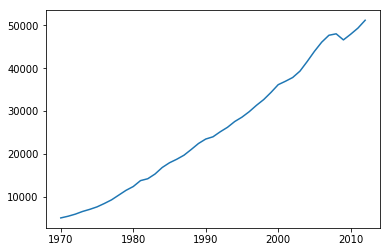

In [2]:
data = np.genfromtxt("podatki/GDP-USD-countries.csv", delimiter=",")

i = 205
x = data[0, 1:]
y = data[i, 1:]
n = len(x)

plt.figure()
plt.plot(x, y)
plt.show()

Uporabili bomo tipično funkcijo kovariance, eksponentno-kvadratno funkcijo (ang. "Exponentiated-quadratic" oz. "RBF"), dano z izrazom

$$ k(t, t') = exp\{-\frac{\|t-t'\|^2}{2\ell^2}\} $$

kjer parametru $\ell$ pravimo dolžina vpliva (ang. <i>lengthscale</i>).

 F:\Anaconda\lib\site-packages\matplotlib\figure.py:1999: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


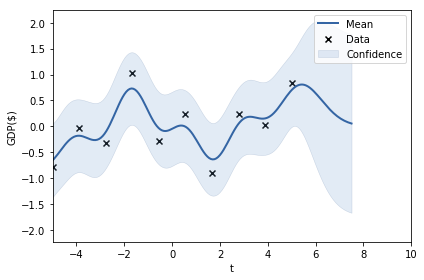

In [3]:
resolution = 10

t = np.linspace(-5, 5, resolution)
x = np.sin(t)    * np.cos(2*t) + 0.2*np.random.rand(1, resolution).ravel()

t = t.reshape((len(t), 1))[0::1]
x = x.reshape((len(x), 1))[0::1]

x = x - x.mean()

# Gaussian kernel, RBF, sq exp, exponentiated quadratic, stationary kernel
kernel = GPy.kern.RBF(input_dim=1, lengthscale=1)
model = GPy.models.GPRegression(t, x, kernel, noise_var=0.1) # noise_var=10.0

# model.optimize(messages=True)
model.plot(lower=5, upper=95)
plt.gca().set_xlabel("t")
plt.gca().set_ylabel("GDP($)")
plt.xlim(-5, 10)
plt.show()

Dobimo model neparametrične regresije, ki nam omogoča ekstrapolacijo v naslednja leta. Opazimo, da se negotovost (varianca) napovedi povečuje, s tem ko se oddaljujemo od podatkov.

### Kovariančne funkcije

Kovariačne funkcije bistveno vplivajo na <i>obliko družine funkcij</i>, ki jih vzorčimo iz Gaussovega Procesa. Oglejmo si nekaj tipičnih primerov kovariačnih funkcij. Bodite pozorni na lastnosti družine funkcij.

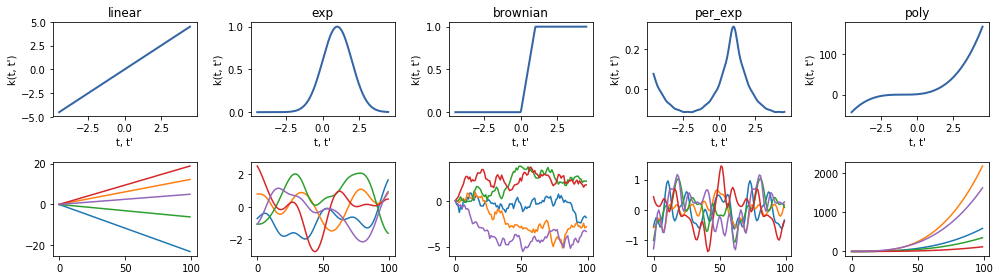

In [4]:
kernels = [ GPy.kern.Linear, GPy.kern.RBF, GPy.kern.Brownian, GPy.kern.PeriodicExponential, GPy.kern.Poly]
names = ["linear", "exp", "brownian", "per_exp", "poly"]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(14, 4)) 
for i, k, name in zip(range(5), kernels, names):
    
    # Narisi funkcijo kovariance
    knl = k(input_dim=1)
    knl.plot(x=1, ax=axes[0][i])
    axes[0][i].set_xlabel("t, t'")
    axes[0][i].set_ylabel("k(t, t')")
    axes[0][i].set_title(name)
    
    # Narisi vzorce iz druzine funkcij
    X = np.linspace(0, 10, 100).reshape((100, 1))
    mu = np.zeros((100, ))
    C = knl.K(X,X) 
    Z = np.random.multivariate_normal(mu,C,5)
    for z in Z:
        axes[1][i].plot(z)
    
fig.tight_layout()
plt.show()

Oglejmo si nekoliko bolj zanimiv signal. Spodnji podatki prikazujejo koncentracijo ogljikovega diosksida ($CO_2$) v ozračju od leta 1960.

In [5]:
co2 = np.genfromtxt("podatki/co2.csv", delimiter=",", skip_header=1)


n = len(co2)

t = co2[:, 0].reshape((n, 1))
x = co2[:, 2].reshape((n, 1)) 
x = x - x.mean()
co2

array([[1.00000000e+00, 1.95900000e+03, 3.15420000e+02],
       [2.00000000e+00, 1.95908333e+03, 3.16310000e+02],
       [3.00000000e+00, 1.95916667e+03, 3.16500000e+02],
       ...,
       [4.66000000e+02, 1.99775000e+03, 3.60830000e+02],
       [4.67000000e+02, 1.99783333e+03, 3.62490000e+02],
       [4.68000000e+02, 1.99791667e+03, 3.64340000e+02]])

Opazimo sezonsko periodično spreminjanje signala, v kombinaciji z naraščajočim trendom.

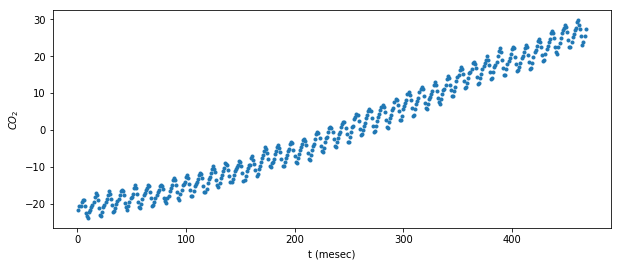

In [6]:
plt.figure(figsize=(10, 4))
plt.plot(t, x, ".")
plt.ylabel("$CO_2$")
plt.xlabel("t (mesec)")
plt.show()

<font color="green"><b>Naredi sam/a.</b></font> S seštevanjem kovariančnih funkcij poizkušaj modelirati podatke o koncetraciji $CO_2$. Poizkusi najto kombinacijo funkcij, ki najbolje ekstrapolirajo koncentracijo $CO_2$ v prihodnja leta.

A Jupyter Widget

(200, 600)

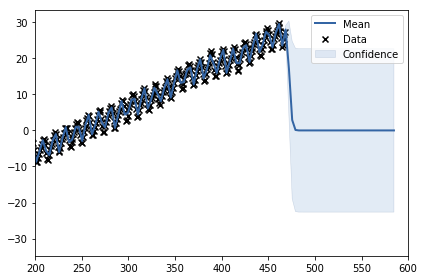

In [7]:
kernel = GPy.kern.RBF(1, lengthscale=1)
model  = GPy.models.GPRegression(t, x, kernel, noise_var=0.1)
model.optimize(messages=True)
model.plot()
plt.gca().set_xlim(200, 600)